In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys,os,glob
sys.path.append('./sailfish/')
if not (os.path.isdir('data') or os.path.islink('data')):
    os.mkdir('data')


In [30]:
%%writefile from_geo.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTHalfBBWall, NTEquilibriumVelocity,NTGuoDensity, NTEquilibriumDensity, NTRegularizedDensity,DynamicValue, NTFullBBWall
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim, LBForcedSim
from sailfish.sym import S

from sympy import sin, Piecewise

class MyBlock(Subdomain2D):
    max_v = 0.025
    
    def boundary_conditions(self, hx, hy):
        if hasattr(self.config, '_geo_map'):
            rampup_time = 5000
            wall_map = self.config._geo_map == 0
           
            partial_wall_map = self.select_subdomain(
                wall_map, hx, hy)
            
            radius = self.config._D / 2.0
            radius_sq = radius**2
            vv =  self.max_v * (1.0 -  (S.gy + 0.5 - radius)**2 / radius_sq)* \
                        Piecewise((S.time / rampup_time, S.time < rampup_time),(1.0, True))
            
            
            self.set_node((~wall_map) & (hx == 0), NTEquilibriumVelocity(DynamicValue(vv,0.0)))
            
            
            self.set_node(partial_wall_map, NTFullBBWall)
            self.set_node((~wall_map) & (hx == self.gx), NTEquilibriumDensity(1.0))
            

        
        # Only used with node_addressing = 'indirect'.
    def load_active_node_map(self, hx, hy):
        partial_wall_map = self.select_subdomain(
            self.config._wall_map, hx, hy)
        self.set_active_node_map_from_wall_map(partial_wall_map)
        
        
    
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0 
        #sim.vy[:] = 0.0
        #hhy = hy - NTFullBBWall.location
        #sim.vx[:] = 4.0 * self.max_v / self.gy**2 * hhy * (self.gy - hhy)
        
        sim.vx[:] = 0.0
        sim.vy[:] = 0.0

class MySim(LBFluidSim):
    
    subdomain = MyBlock


    @classmethod
    def add_options(cls, group, dim):
        group.add_argument('--geometry', type=str, default='')   
        
        
    @classmethod
    def modify_config(cls, config):
        if not config.geometry:
            return

        # Override lattice size based on the geometry file.
        data = np.load(config.geometry)  
        config.lat_ny, config.lat_nx = data['geo'].shape
        # Add nodes corresponding to ghosts. Assumes an envelope size of 1.
        geo_map = data['geo']
        geo_map = np.pad(geo_map, (1, 1), 'constant', constant_values=0)
        config._geo_map = geo_map
        config._D = data['D']
        config._L = data['L']
        
    def __init__(self, config):
        super(MySim, self).__init__(config)

#G = np.load("Geo01.npz")
#NX,NY = G['geo'].shape
LBSimulationController(MySim).run()

Overwriting from_geo.py


In [31]:
%%bash
source activate py27
#rm data/from_geo*.npz
dir=$PWD
#parentdir="$(dirname "$dir")"
export PYTHONPATH=$dir/sailfish_team/
python2 from_geo.py --max_iters=100000 --from=0 --every=10000 \
  --visc=0.1 \
 --output="data/broken_pipe/from_geo" --output_format=npy --geometry="broken_pipe_2d_geometry.npz" --gpu=1 

[   951  INFO Master/gpu2.smcebi.us.edu.pl] Machine master starting with PID 24821 at 2017-11-28 11:58:52 UTC
[   952  INFO Master/gpu2.smcebi.us.edu.pl] Simulation started with: from_geo.py --max_iters=100000 --from=0 --every=10000 --visc=0.1 --output=data/broken_pipe/from_geo --output_format=npy --geometry=broken_pipe_2d_geometry.npz --gpu=1
[   967  INFO Master/gpu2.smcebi.us.edu.pl] Sailfish version: 98ec98ed0e406378e5a31c3886a6d2937e71848f
[   967  INFO Master/gpu2.smcebi.us.edu.pl] Handling subdomains: [0]
[   967  INFO Master/gpu2.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 1}
[   968  INFO Master/gpu2.smcebi.us.edu.pl] Selected backend: cuda
[   973  INFO Subdomain/0] SubdomainRunner starting with PID 24826
[  2347  INFO Subdomain/0] Initializing subdomain.
[  2348  INFO Subdomain/0] Relaxation model: bgk
[  2349  INFO Subdomain/0] Actual lattice size is: [1223, 405]
[  2350  INFO Subdomain/0] Required memory: 
[  2350  INFO Subdomain/0] . distributions: 34 MiB
[  2350  INFO Su

In [32]:
result = np.load("data/broken_pipe/from_geo.0.100000.npz")

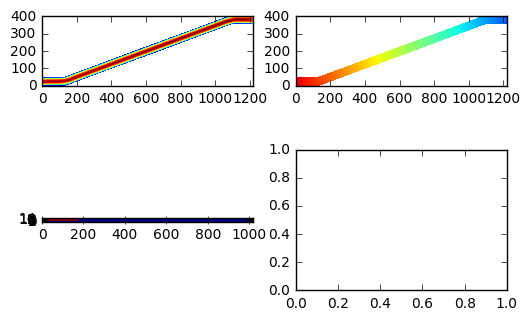

In [33]:
vx = result['v'][0]#[:15,:15]
vy = result['v'][1]#[:15,:15]
rho = result['rho']#[:15,:]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow((vx**2+vy**2)**0.5,origin='lower',interpolation='nearest')
#ax1.set_title('Sharing x per column, y per row')
ax2.imshow(rho,origin='lower',interpolation='nearest')
ax3.imshow(geo_map[:15,:],origin='lower',interpolation='nearest')
#ax4.plot(x, 2 * y ** 2 - 1, color='r')





#plt.imshow((vx**2+vy**2)**0.5,origin='lower',interpolation='nearest')
#plt.imshow(rho,origin='lower',interpolation='nearest')
#plt.axis('equal')
#plt.grid(color='b', linestyle='-', linewidth=1, alpha = 0.3)
#plt.colorbar()

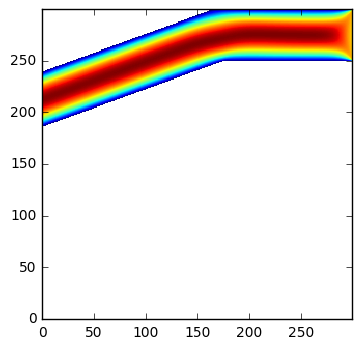

In [37]:
plt.imshow((vx[-300:,-300:]**2+vy[-300:,-300:]**2)**0.5,origin='lower',interpolation='nearest')

In [178]:
result['rho'].shape

(517, 55)

In [133]:
0.0040960

0.004096

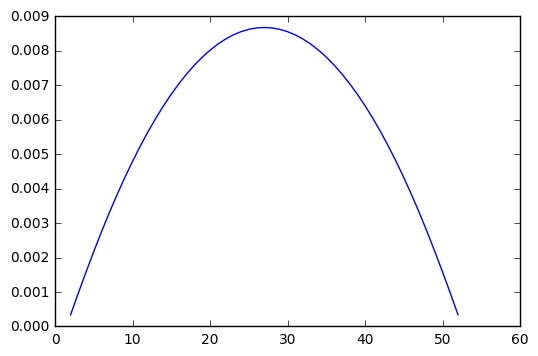

In [153]:
plt.plot(result['v'][1][5,:])

In [156]:
8*0.025*0.1*512/((50)**2) 

0.004096000000000001

In [259]:
 result['rho'].shape

(519, 93)

In [7]:
data = np.load("broken_pipe_2d_geometry.npz")  
        
geo_map = data['geo']
geo_map = np.pad(geo_map, (1, 1), 'constant', constant_values=0)


In [263]:
import pprint
result['rho'][:15,:15]

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, 